<a href="https://colab.research.google.com/github/aminecloud9/PFE/blob/main/CICIDS2017_LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import LSTM, SimpleRNN, GRU
from keras.datasets import imdb
from keras.utils.np_utils import to_categorical
from sklearn.metrics import (precision_score, recall_score,
                             f1_score, accuracy_score,mean_squared_error,mean_absolute_error)
from sklearn import metrics
from sklearn.preprocessing import Normalizer
import h5py
from keras import callbacks
from keras import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from sklearn.preprocessing import StandardScaler
from collections import Counter
from matplotlib import pyplot
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from numpy import where
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import time

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Download dataset

In [2]:
data=pd.read_csv('/content/drive/MyDrive/globalData.csv')
#Labels=pd.read_csv('/content/drive/MyDrive/CICIDS2017_Labels.csv')

In [3]:
Y = data.values[:,-1]
X = data.iloc[: , :-1]
Y=pd.factorize(Y)

Class=0, n=2273097 (80.300%)
Class=1, n=128027 (4.523%)
Class=2, n=158930 (5.614%)
Class=3, n=1966 (0.069%)
Class=4, n=36 (0.001%)
Class=5, n=1507 (0.053%)
Class=6, n=652 (0.023%)
Class=7, n=21 (0.001%)
Class=8, n=7938 (0.280%)
Class=9, n=5897 (0.208%)
Class=10, n=5796 (0.205%)
Class=11, n=5499 (0.194%)
Class=12, n=231073 (8.163%)
Class=13, n=10293 (0.364%)
Class=14, n=11 (0.000%)


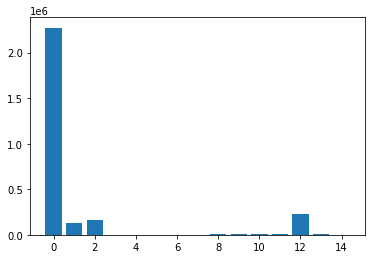

In [ ]:
# summarize distribution
counter = Counter(Y[0])
for k,v in counter.items():
	per = v / len(Y[0]) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprec

Counter({0: 652, 1: 652, 2: 652, 3: 652, 4: 652, 5: 652, 6: 652, 7: 652, 8: 652, 9: 652, 10: 652, 11: 652, 12: 652, 13: 652, 14: 652})


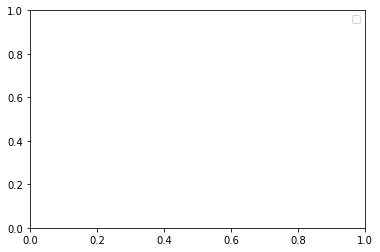

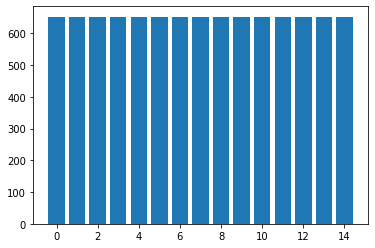

In [5]:
# Oversample and plot imbalanced dataset with SMOTE

# define pipeline
strategy = {0:652, 1:652, 2:652, 3:652, 5:652, 6:652, 8:652, 9:652, 10:652, 11:652, 12:652, 13:652 }
oversample = SMOTE(sampling_strategy={4:652, 7:652, 14:652})
under = RandomUnderSampler(sampling_strategy=strategy)
steps = [('u', under),('o',oversample)]
pipeline = Pipeline(steps=steps)
# transform the dataset
#oversample = SMOTE()
X= np.nan_to_num(X)
X, Y = pipeline.fit_resample(X, Y[0])
# summarize the new class distribution
counter = Counter(Y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(Y == label)[0]
	#pyplot.scatter([row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

pyplot.bar(counter.keys(), counter.values())
pyplot.show()

Data scaling

In [6]:
scaler = StandardScaler()
X= np.nan_to_num(X)
X = scaler.fit_transform(X)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:808: RuntimeWarning: invalid value encountered in true_divide
  X /= self.scale_


Split dateset

In [7]:
#Import Module
from sklearn.model_selection import train_test_split


train_X, test_X, train_y, test_y = train_test_split(X, Y, 
                                                     train_size=0.7,
                                                     test_size=0.3,
                                                     random_state=122)

In [ ]:
del(X)
del(Y)

In [ ]:
train_X= np.nan_to_num(train_X)

In [ ]:
train_X[:,pd.isna(train_X).any()].tolist()

In [ ]:
# reshape input to be [samples, time steps, features]
import keras

#X_train = np.reshape(data.values[:,:-1].astype('float32'), (data.values[:,:-1].shape[0], 1, data.values[:,:-1].shape[1]))
X_train = np.reshape(train_X.astype('float32'), (train_X.shape[0], 1, train_X.shape[1]))
X_test = np.reshape(test_X.astype('float32'), (test_X.shape[0], 1, test_X.shape[1]))
#y_train = keras.utils.to_categorical(pd.factorize(data.values[:,77])[0],15)
test_y = pd.factorize(test_y)
train_y = pd.factorize(train_y)
y_train = keras.utils.to_categorical(train_y[0],train_y[1].shape[0])
y_train = y_train.astype('int')
y_train = np.reshape(y_train,(y_train.shape[0],1,y_train.shape[1]))
y_test = keras.utils.to_categorical(test_y[0],train_y[1].shape[0])
y_test = y_test.astype('int')
y_test = np.reshape(y_test,(y_test.shape[0],1,y_test.shape[1]))

In [ ]:
import time
data_dim = X_train.shape[2]
timesteps = 1
num_classes = y_train.shape[2]
batch_size = 1

model = Sequential()
model.add(LSTM(50, return_sequences=True, stateful=False, batch_input_shape=(batch_size, timesteps, data_dim)))
model.add(Dropout(0.1))
model.add(LSTM(50, return_sequences=True, stateful=False))
model.add(Dropout(0.1))
model.add(LSTM(50, stateful=True))
model.add(Dropout(0.1))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


start = time.time()

start_time = time.time()
model.fit(X_train, y_train,batch_size=batch_size, epochs=2, shuffle=False)
finish_time = time.time() - start_time
#model.save("/content/drive/My Drive/final_model_NSL-KDD_brute_Multiclass.h5")

In [ ]:
from keras.layers.advanced_activations import LeakyReLU

In [ ]:
train_X[:,2]

array([-0.30164428, -0.30291488, -0.30037367, ..., -0.29275002,
       -0.30037367, -0.30164428])

In [ ]:
#train_object_num=len(train_data)
#print(test[0])
#model training
batch_size = 512
model=Sequential()
model.add(LSTM(X_train.shape[2],input_dim=X_train.shape[2],return_sequences=True,kernel_initializer='uniform',activation='relu'))
model.add(LSTM(32,kernel_initializer='uniform',return_sequences=True,activation='relu'))
#model.add(LSTM(128,kernel_initializer='uniform',return_sequences=True,activation='relu'))
#model.add(Dense(256,activation='relu'))
#model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
#model.add(Dense(16,activation='relu'))
model.add(Dense(y_train.shape[2],activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='NADAM',metrics=['accuracy'])
model.summary()
start_time = time.time()
history = model.fit(X_train,y_train,validation_split=.3,epochs=100,batch_size=batch_size,verbose=1)
finish_time = time.time() - start_time
#model.save("/content/drive/My Drive/model_CICIDS_brute_data_valsplit.3.h5")

NameError: ignored

In [ ]:
print(np.any(np.isnan(X_train)))
print(np.any(np.isnan(y_train)))

False
False


In [ ]:
batch_size= 16
lrate = 0.01
DROPOUTRATE = 0.3
model = Sequential()
model.add(Dense(X_train.shape[2], input_dim=X_train.shape[2], activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(DROPOUTRATE))
model.add(Dense(768, activation='relu'))
model.add(Dropout(DROPOUTRATE))
model.add(Dense(512, activation='relu'))
model.add(Dropout(DROPOUTRATE))
model.add(Dense(256, activation='relu'))
model.add(Dropout(DROPOUTRATE))
model.add(Dense(128, activation='relu'))
model.add(Dropout(DROPOUTRATE))
model.add(Dense(y_train.shape[2], activation='softmax'))
	# compile model
opt = SGD(lr=lrate)
#loss = categorical_focal_loss([67343,45927,995,11656,52])
model.compile(loss= 'categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# fit model
model.summary()
start_time = time.time()
history = model.fit(X_train, y_train, validation_data = (X_test,y_test),batch_size=batch_size, epochs=100, verbose=1)
finish_time = time.time() - start_time

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_93 (Dense)             (None, 77)                6006      
_________________________________________________________________
dense_94 (Dense)             (None, 1024)              79872     
_________________________________________________________________
dropout_65 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_95 (Dense)             (None, 768)               787200    
_________________________________________________________________
dropout_66 (Dropout)         (None, 768)               0         
_________________________________________________________________
dense_96 (Dense)             (None, 512)               393728    
_________________________________________________________________
dropout_67 (Dropout)         (None, 512)             

In [ ]:
loss, accuracy = model.evaluate(X_train,y_train)
print("\nLoss: %.2f, Accuracy: %.2f%%" % (loss, accuracy*100))
y_pred = model.predict_classes(X_train)
print("execution time :  ",finish_time)

214/214 [==============================] - 1s 5ms/step - loss: 0.2206 - accuracy: 0.8926

Loss: 0.22, Accuracy: 89.26%


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


execution time :   459.9898386001587


In [ ]:
#saving model
model.save("/content/drive/MyDrive/NSL-KDD_results_3LSTM_1Dense_20epoch_1batch_model.h5")

In [ ]:
from keras.models import load_model
#model = load_model('/content/drive/MyDrive/NSL-KDD_results_SimpleRNN_model.hdf5')
loss, accuracy = model.evaluate(X_test, y_test)
print("\nLoss: %.2f, Accuracy: %.2f%%" % (loss, accuracy*100))

#print("--- %s seconds ---",finish_time)
y_pred = model.predict_classes(X_train)
#np.savetxt('/content/drive/MyDrive/NSL-KDD_results_SimpleRNN_predicted.txt', np.transpose([y_test,y_pred]), fmt='%s')

92/92 [==============================] - 1s 6ms/step - loss: nan - accuracy: 0.0641

Loss: nan, Accuracy: 6.41%


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
